In [1]:
%matplotlib inline
#%matplotlib notebook
%load_ext version_information
%load_ext autoreload


In [16]:
import bisect
import datetime
import os
import sys
import warnings

warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import numpy as np
import spacepy.datamodel as dm
import spacepy.plot as spp
import spacepy.toolbox as tb
import spacepy.time as spt
import scipy
import tqdm

%version_information matplotlib, numpy

Software versions
Python 3.5.2 64bit [GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
IPython 5.1.0
OS Darwin 15.6.0 x86_64 i386 64bit
matplotlib 1.5.3
numpy 1.11.1
Wed Feb 15 18:04:06 2017 MST

In [3]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['savefig.dpi'] = plt.rcParams['figure.dpi'] # 72
%config InlineBackend.figure_format = 'retina'

In [4]:
#  1 YEAR                          I4        
#  2 DOY                           I4        
#  3 Hour                          I3        
#  4 Scalar B, nT                  F6.1      
#  5 BZ, nT (GSM)                  F6.1      
#  6 SW Plasma Speed, km/s         F6.0      
#  7 Dst-index, nT                 I6  

fname = 'omni2_21972.lst'
data = np.loadtxt(fname)
print(data.shape)

(228648, 7)


In [5]:
# make the datetime
tm = data[:,0:3].astype(int)
# year = data[:,0]
# doy = data[:,1]
# hour = data[:,2]

dt = np.asarray([datetime.datetime.strptime('{0:04}{1:03}{2:02}'.format(y,d,h), '%Y%j%H') for y,d,h in tm])

In [6]:
# grab the data into a numpy record array
dtype = [('DT', object), ('B', float), ('Bz', float), ('Vsw', float), ('Dst', int)]
# dat = np.array(data[:,3:], dtype=[('B', float), ('Bz', float), ('Vsw', float), ('Dst', int)])
dat = np.ma.zeros(data.shape[0], dtype=dtype) 
# dat

dat['DT'][:] = dt
dat['B'][:] = np.ma.masked_greater_equal(data[:,3], 999.9)
dat['Bz'][:] = np.ma.masked_greater_equal(data[:,4], 999.9)
dat['Vsw'][:] = np.ma.masked_greater_equal(data[:,5], 9999.)
dat['Dst'][:] = data[:,6]


In [7]:
print(np.asarray(dat['DT']).min(), np.asarray(dat['DT']).max())
print(np.asarray(dat['DT'])[0:10])

1990-01-01 00:00:00 2016-01-31 23:00:00
[datetime.datetime(1990, 1, 1, 0, 0) datetime.datetime(1990, 1, 1, 1, 0)
 datetime.datetime(1990, 1, 1, 2, 0) datetime.datetime(1990, 1, 1, 3, 0)
 datetime.datetime(1990, 1, 1, 4, 0) datetime.datetime(1990, 1, 1, 5, 0)
 datetime.datetime(1990, 1, 1, 6, 0) datetime.datetime(1990, 1, 1, 7, 0)
 datetime.datetime(1990, 1, 1, 8, 0) datetime.datetime(1990, 1, 1, 9, 0)]


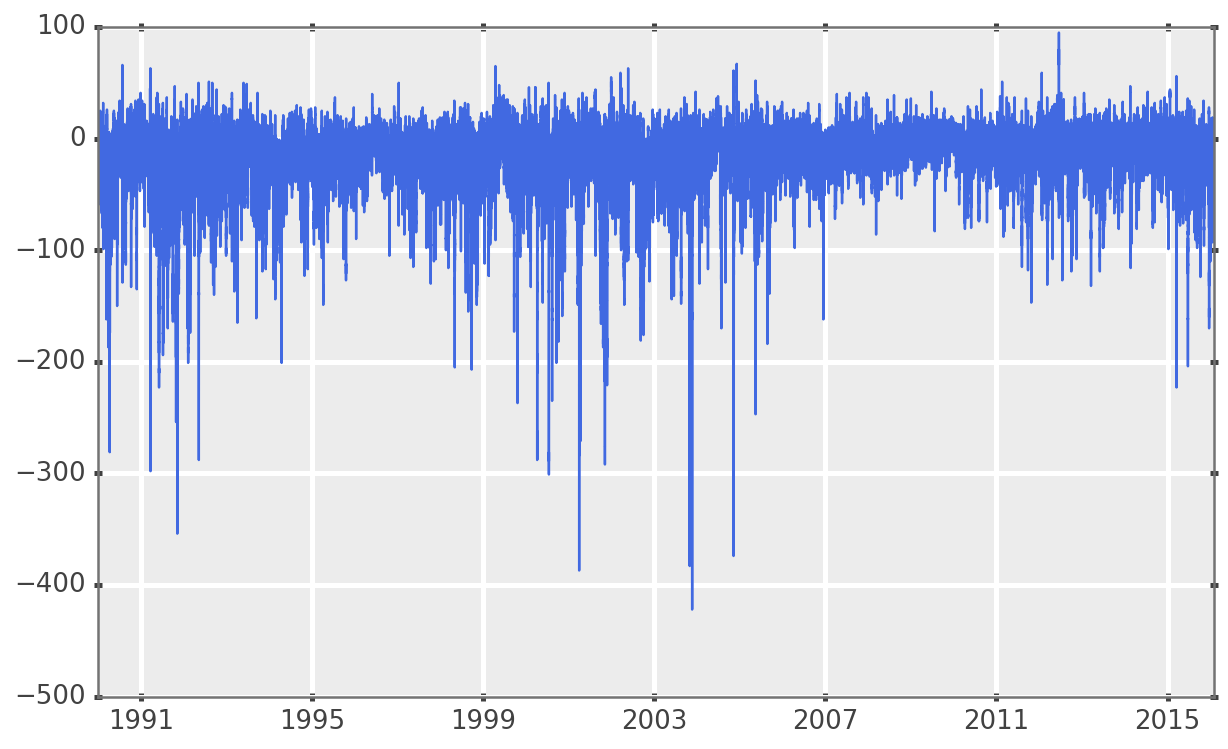

In [8]:
spp.plot(dat['DT'], dat['Dst'])

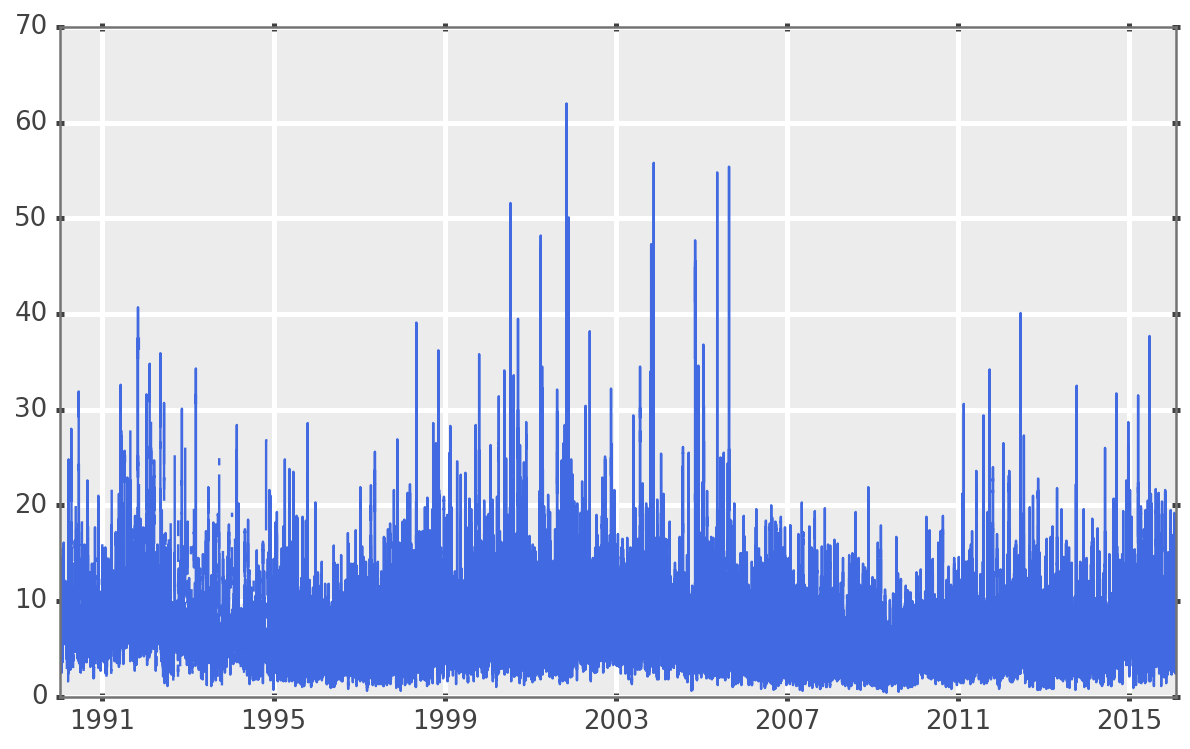

In [9]:
spp.plot(dat['DT'], dat['B'])

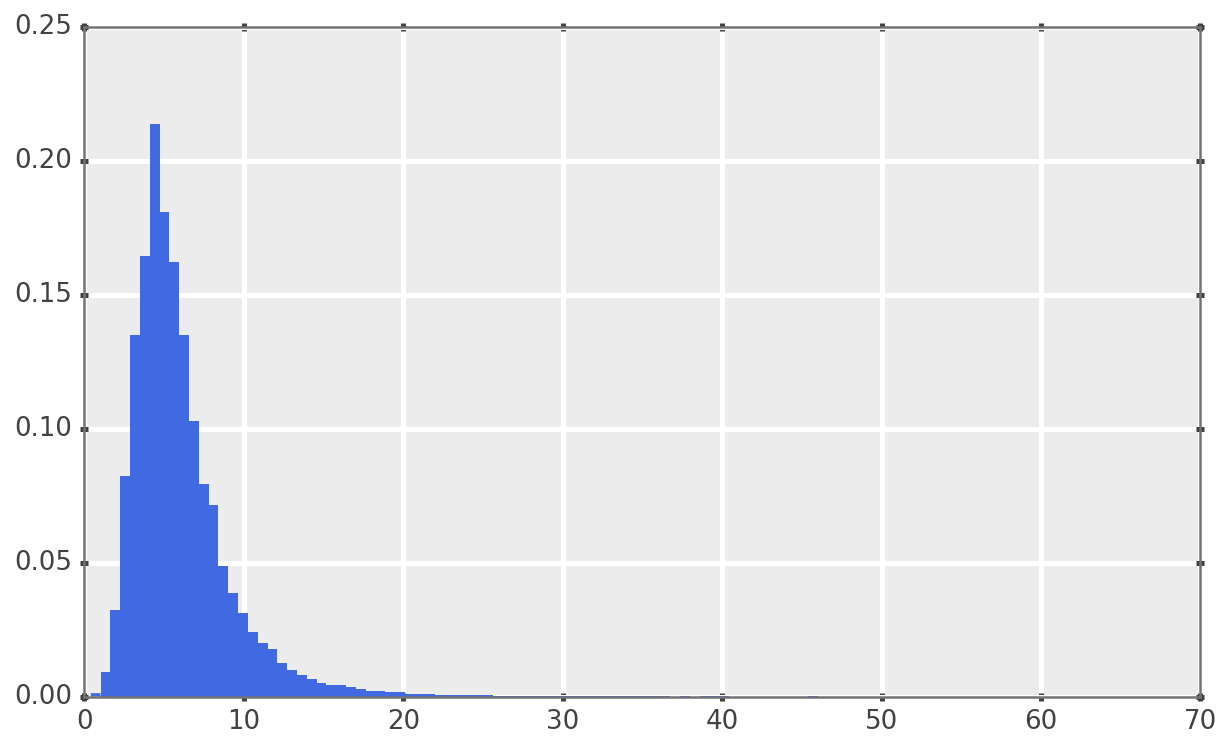

In [10]:
b, h, p = spp.plt.hist(dat['B'].compressed(), 100, normed=True)

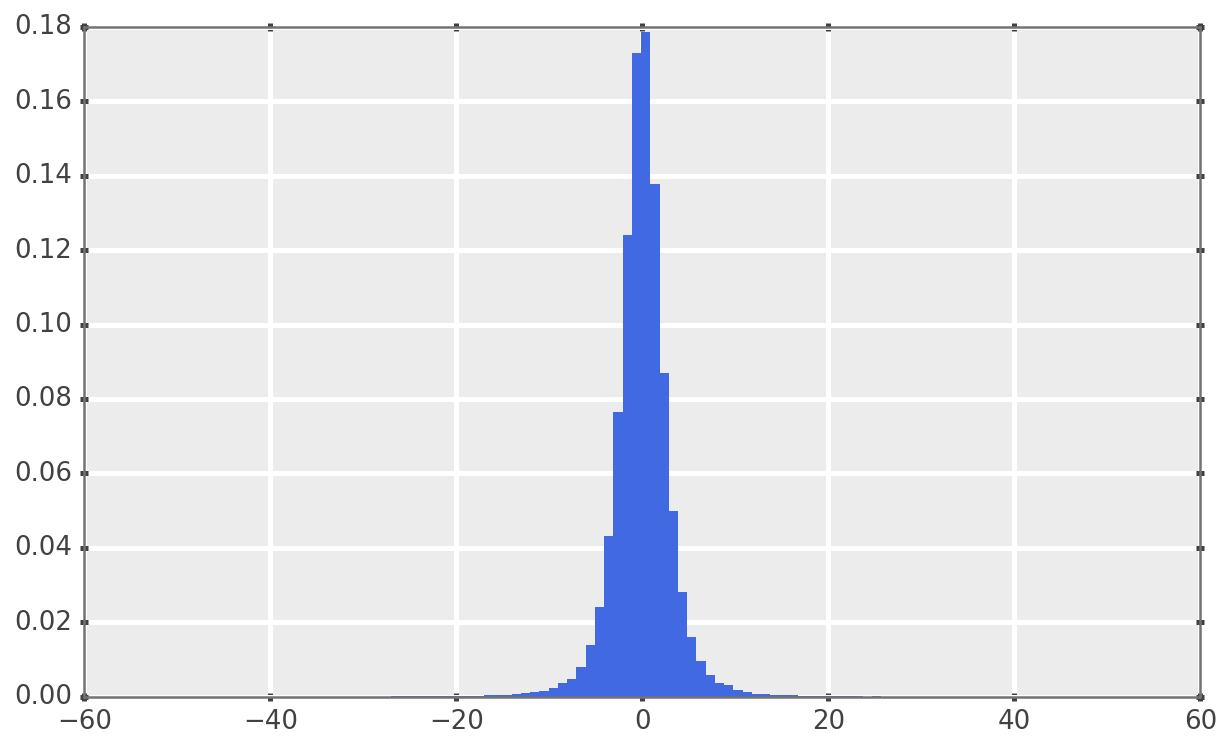

In [11]:
b, h, p = spp.plt.hist(dat['Bz'].compressed(), 100, normed=True)

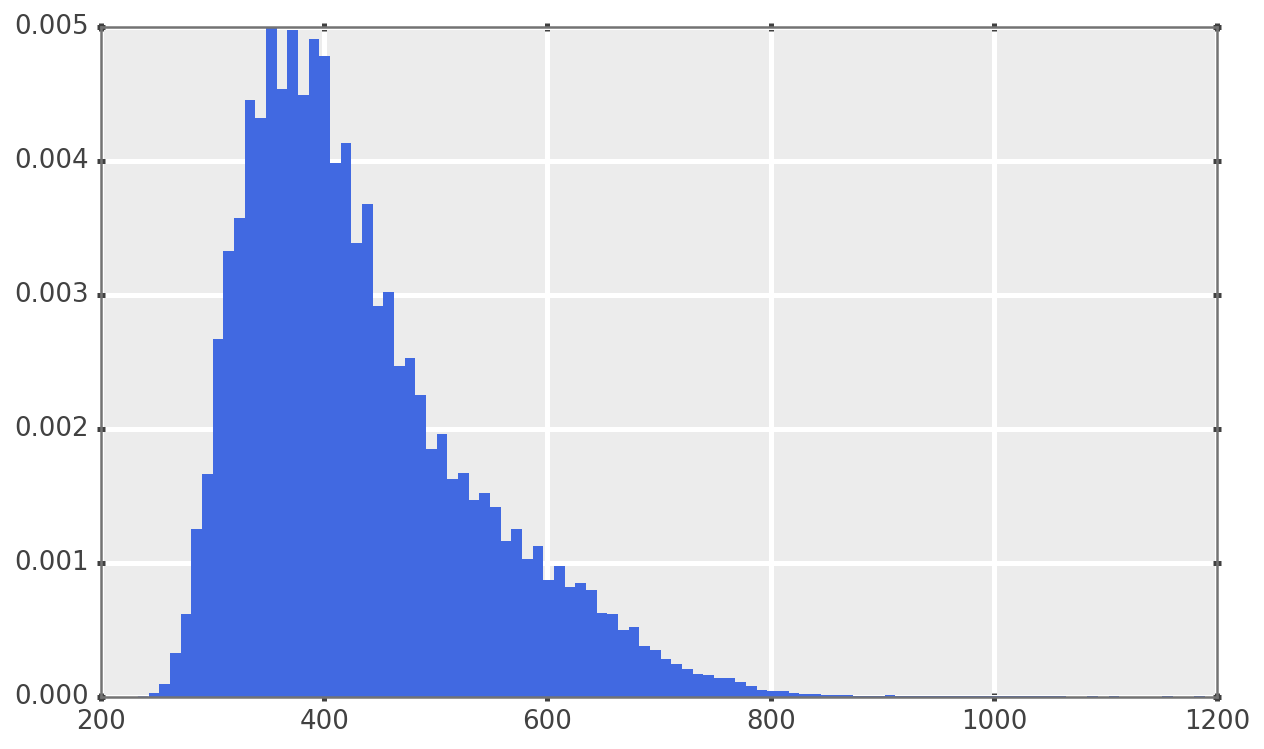

In [12]:
b, h, p = spp.plt.hist(dat['Vsw'].compressed(), 100, normed=True)

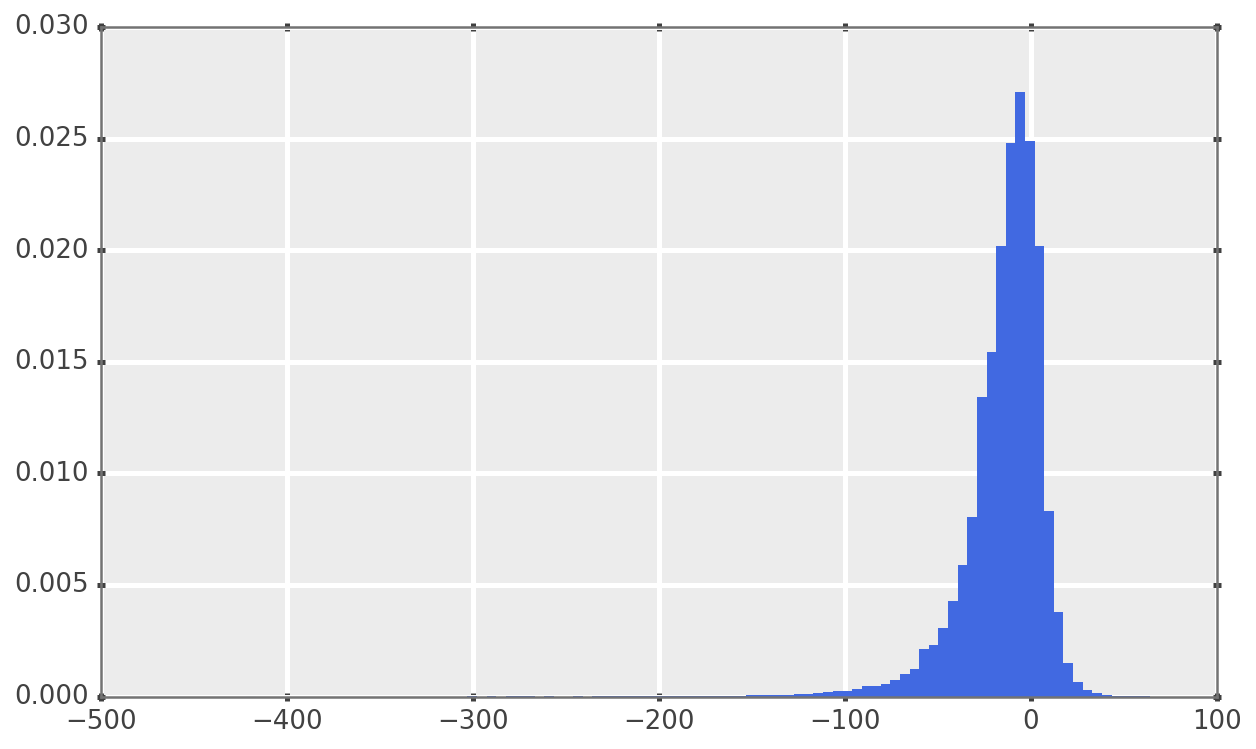

In [13]:
b, h, p = spp.plt.hist(dat['Dst'].compressed(), 100, normed=True)

# Lets now make a block maxima
Take the hourly data and make 1 day blocks of maxima

In [17]:
days = spt.tickrange(np.asarray(dat['DT']).min(), np.asarray(dat['DT']).max(), 1)
B_daily = []
for d1, d2 in tqdm.tqdm_notebook(list(zip(days[:-1], days[1:]))): # not the most efficient, but zip objects have not len
    ind1 = bisect.bisect_right(np.asarray(dat['DT']), d1)
    ind2 = bisect.bisect_right(np.asarray(dat['DT']), d2)
    B_daily.append(dat['B'][ind1:ind2].max())
B_daily = np.asarray(B_daily)

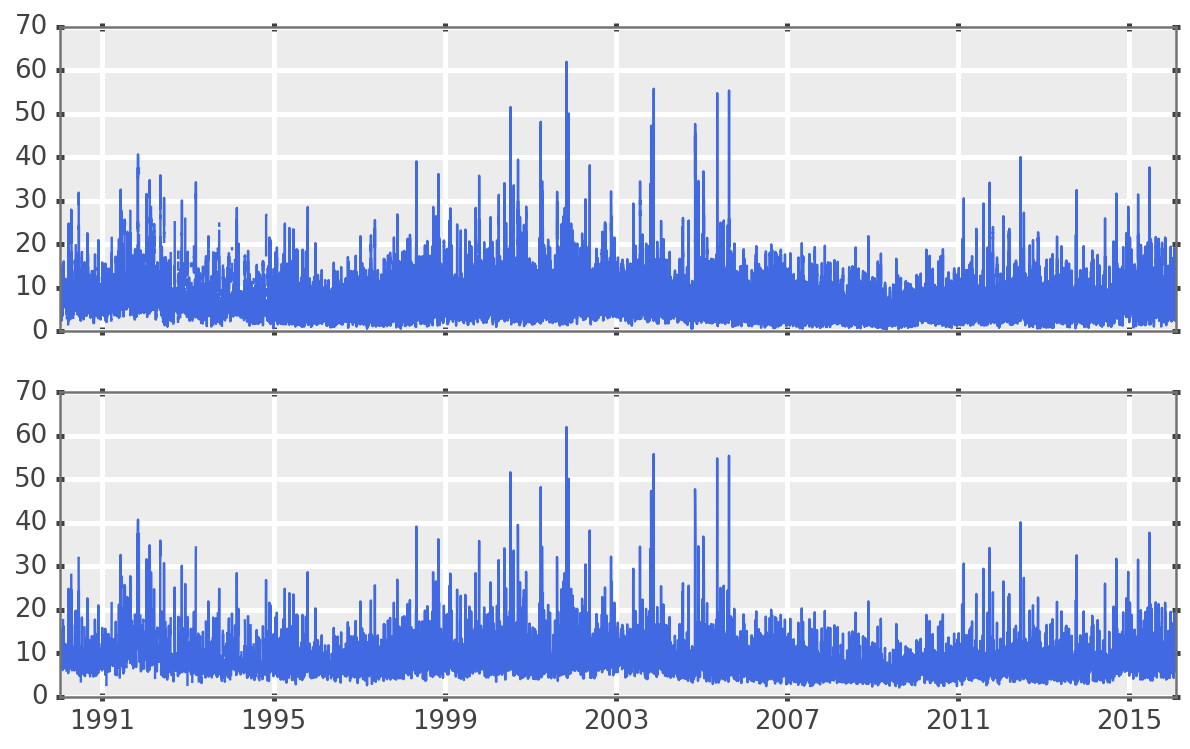

In [18]:
f, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(dat['DT'], dat['B'])
ax[1].plot(days.UTC[0:-1], B_daily)

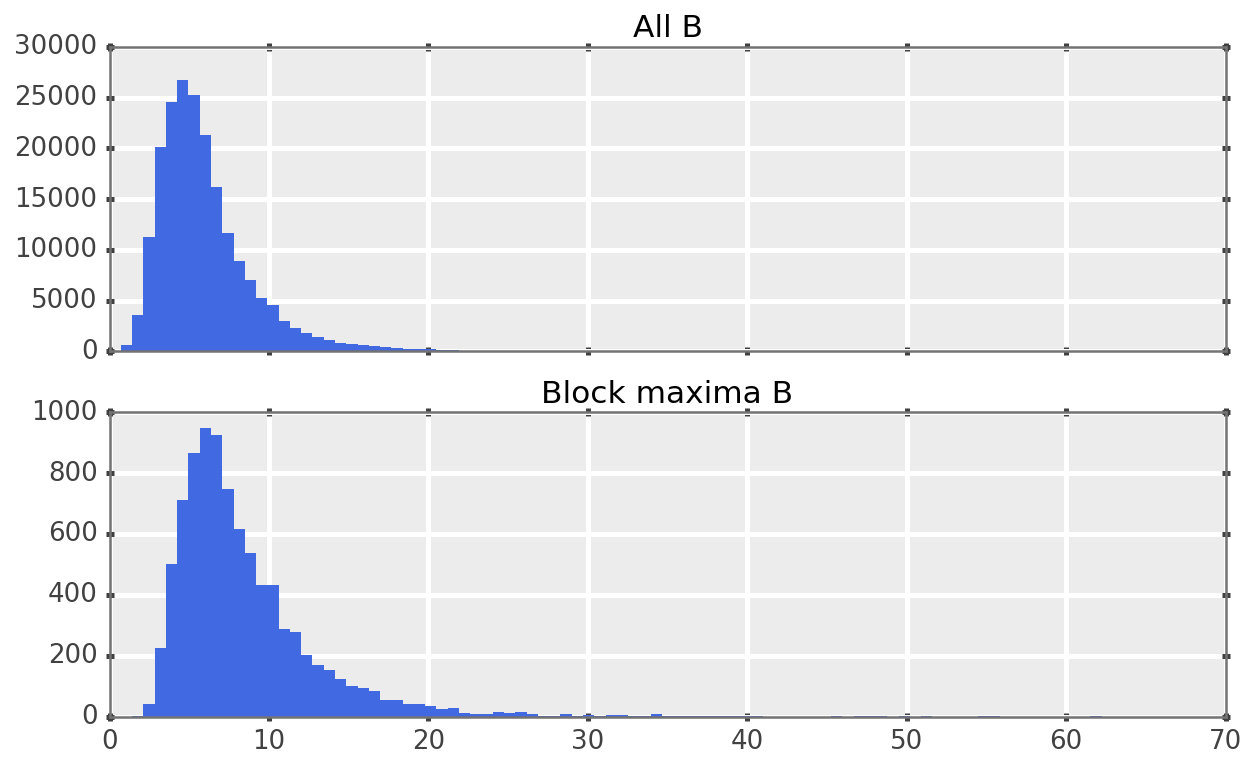

In [19]:
f, ax = plt.subplots(2, 1, sharex=True)
bins = np.linspace(0, 70, 100)
_ = ax[0].hist(dat['B'], bins)
ax[0].set_title('All B');
_ = ax[1].hist(B_daily[np.isfinite(B_daily)], bins)
ax[1].set_title('Block maxima B');


## Now fit this to a generalized extreme value distribution

In [20]:
import pymc3 as mc3

In [21]:
scipy.special.gamma(3.1)

2.1976202783924776

In [22]:
with mc3.Model() as model:
    alpha = mc3.Uniform('alpha', 0, 100, testval=10)
    beta = mc3.Uniform('beta', 0, 100, testval=10)
    weibull = mc3.Weibull('weibull', alpha=alpha, beta=beta, observed=B_daily[np.isfinite(B_daily)]-B_daily[np.isfinite(B_daily)].min()+0.001)
    trace = mc3.sample(10000)



Applied interval-transform to alpha and added transformed alpha_interval_ to model.
Applied interval-transform to beta and added transformed beta_interval_ to model.
Assigned NUTS to alpha_interval_
Assigned NUTS to beta_interval_
 [-----------------100%-----------------] 10000 of 10000 complete in 68.0 sec


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.539            0.246            0.009            [1.507, 1.552]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.508          1.522          1.530          1.538          1.553


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  7.179            0.291            0.009            [7.065, 7.269]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  7.068          7.134          7.170          7.204          7.274



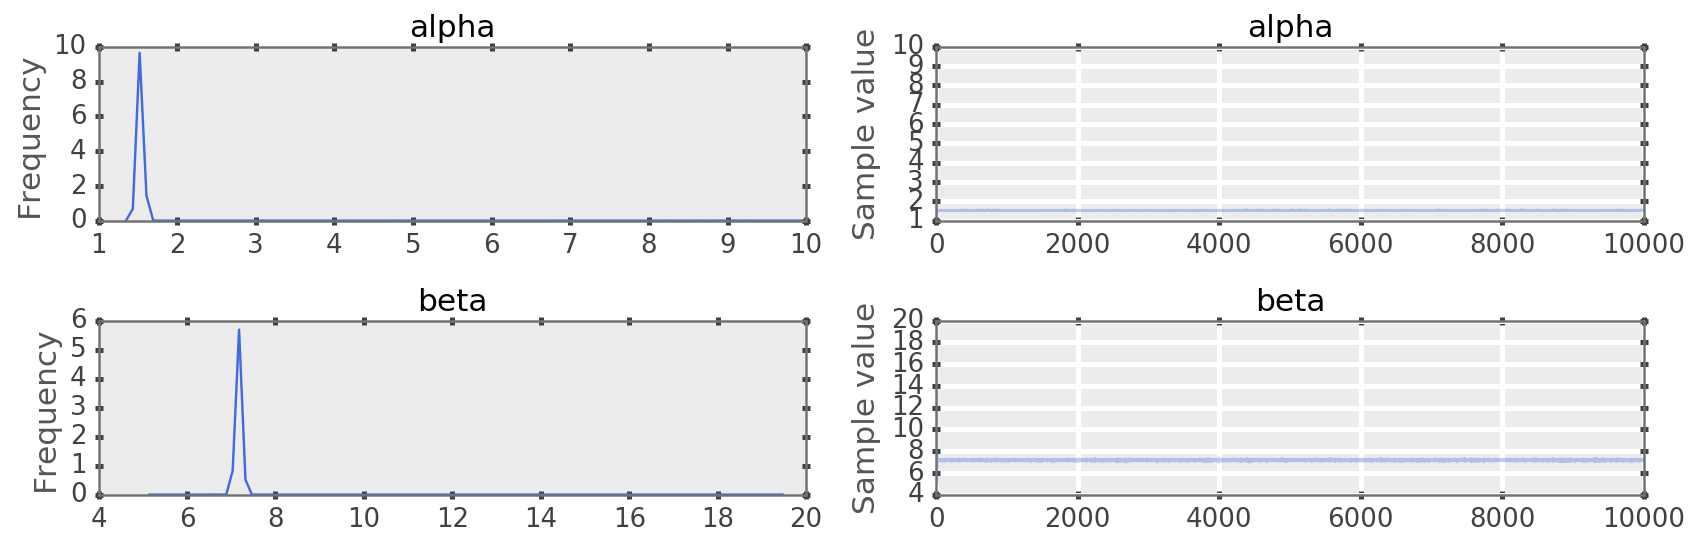

In [23]:
mc3.traceplot(trace);
mc3.summary(trace)

In [24]:
mean = trace['beta']*scipy.special.gamma(1 + 1.0/trace['alpha'])
variance = trace['beta']**2 * scipy.special.gamma(1+ 2.0/trace['alpha'] - mean**2)


In [25]:
with mc3.Model() as model2:
    weibullout = mc3.Weibull('weibullout', alpha=trace['alpha'].mean(), beta=trace['beta'].mean())
    traceout = mc3.sample(100000)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '28684' (I am process '39749')


Applied log-transform to weibullout and added transformed weibullout_log_ to model.
Assigned NUTS to weibullout_log_
 [-----------------100%-----------------] 100000 of 100000 complete in 24.7 sec

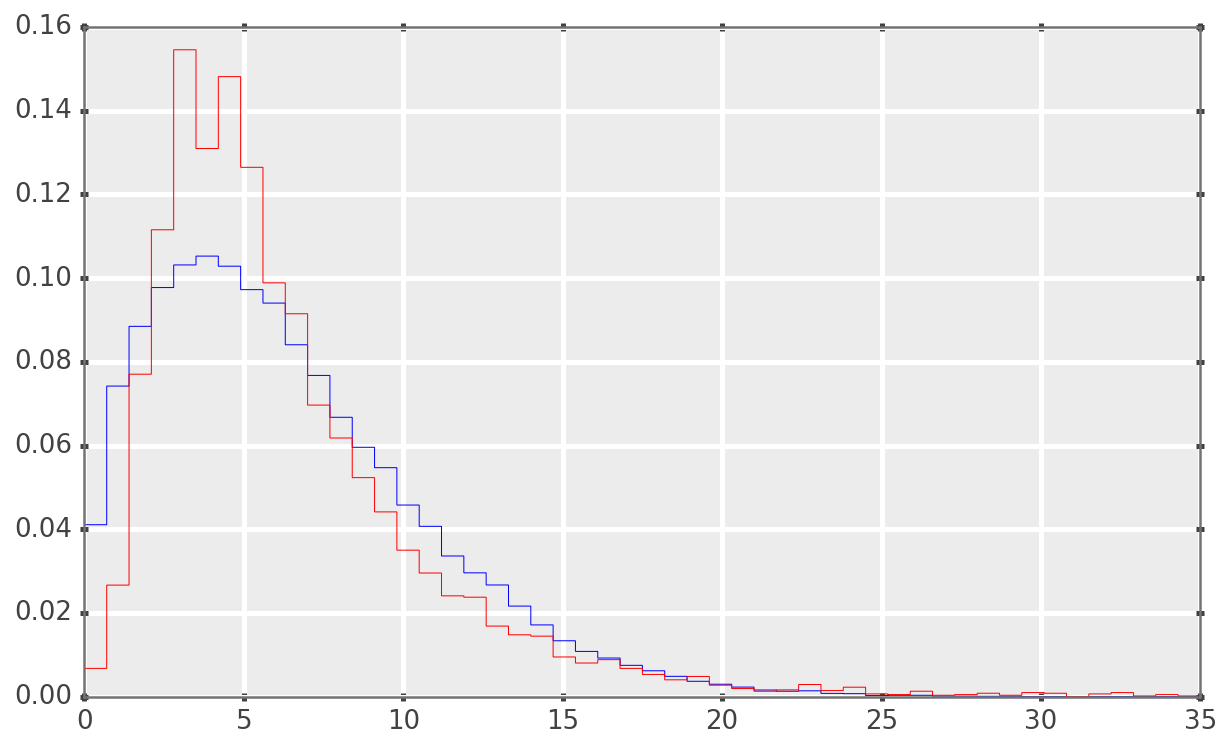

In [26]:
bins = np.linspace(0, 35, 51)
_ = spp.plt.hist(traceout['weibullout'], bins,histtype='step', color='b', normed=True)
_ = spp.plt.hist(B_daily[np.isfinite(B_daily)]-B_daily[np.isfinite(B_daily)].min(), bins,histtype='step', color='r', normed=True)


In [27]:
# integrate to the 1 in 5 year, that is 1 in 5*365
pct = 1.0/(5*365)
hist = np.histogram(traceout[''])
scipy.in

SyntaxError: invalid syntax (<ipython-input-27-04920f6ef0f8>, line 4)

In [ ]:
hist = np.histogram(B_daily[np.isfinite(B_daily)]-B_daily[np.isfinite(B_daily)].min(), bins)
np.trapz(hist[0][0:-1])/np.trapz(hist[0])
hist[1][-1]
print("So is {0} the 1 in {1} chance? This is 1 in {2} days ({3} years) ".format(hist[1][-1], 
      np.trapz(hist[0][0:-1])/np.trapz(hist[0]), 
     1.0/(1-np.trapz(hist[0][0:-1])/np.trapz(hist[0])), 
     1.0/(1-np.trapz(hist[0][0:-1])/np.trapz(hist[0]))/365.))

## GEV dist

In [ ]:
import theano.tensor as T

with mc3.Model() as gev:
    xi = mc3.Uniform('xi', lower=0, upper=60)
    
    def alpha(value=5):
        """Scale parameter"""
        return 1./value
    
    kappa = mc3.Beta('kappa', alpha=5., beta=6.)

    x = [data, kappa, xi, alpha]
    D = mc3.DensityDist('D', lambda x: T.log(mc3.distributions.gev_like(x[0], x[1], x[2], x[3])))
    

    

In [33]:
pymc.gev_like?

In [39]:
import pymc


xi = pymc.Uniform('xi', rseed=True, value=1, lower=0, upper=60, doc='Location parameter')

@pymc.deterministic
def alpha(value=5):
    """Scale parameter"""
    return 1./value

# kappa = pymc.Beta('kappa', rseed=True, alpha=5., beta=6., doc='Shape parameter')
kappa = pymc.Uniform('kappa', -10, 10)


@pymc.data
def D(value=B_daily[np.isfinite(B_daily)], location=xi, scale=alpha, shape=kappa):
   return pymc.gev_like(value, shape, location, scale)

gev_model = pymc.Model((xi, alpha, kappa, D))

 [-----------------100%-----------------] 40000 of 40000 complete in 40.3 secPlotting xi
Plotting kappa
Plotting alpha


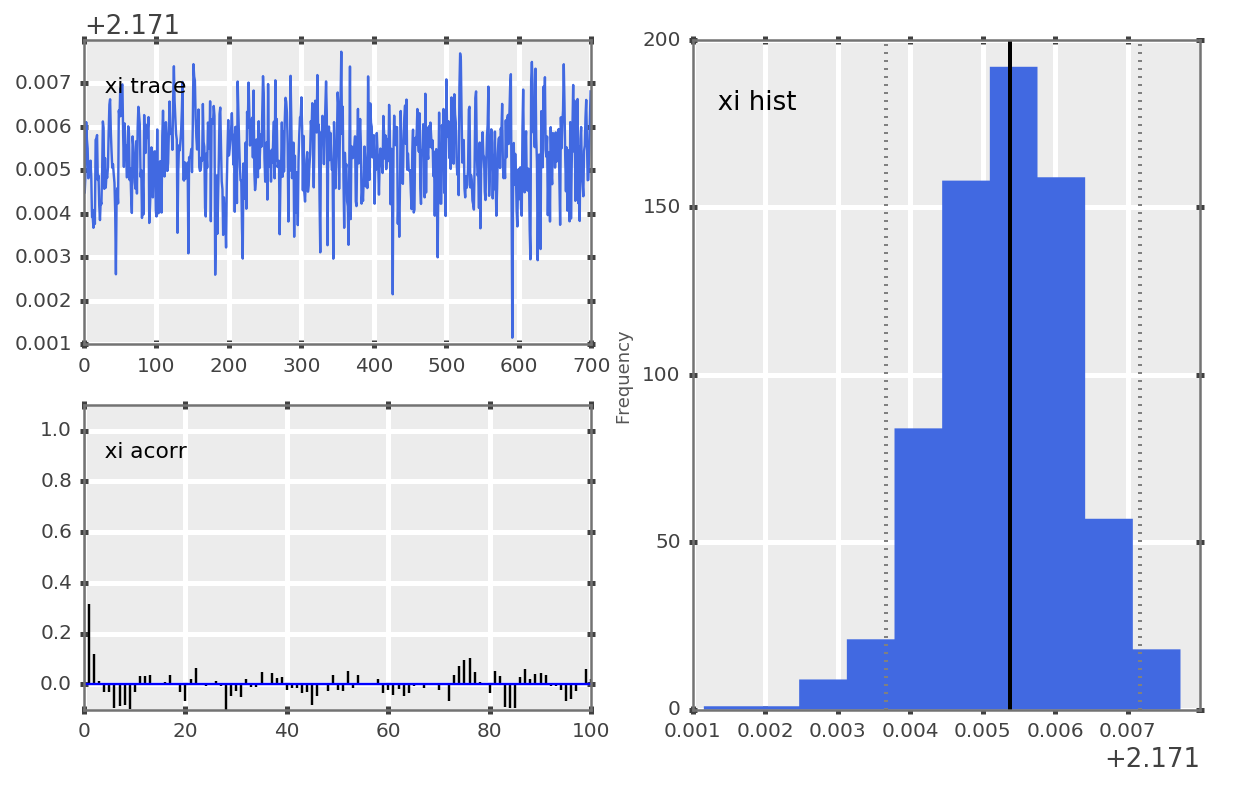

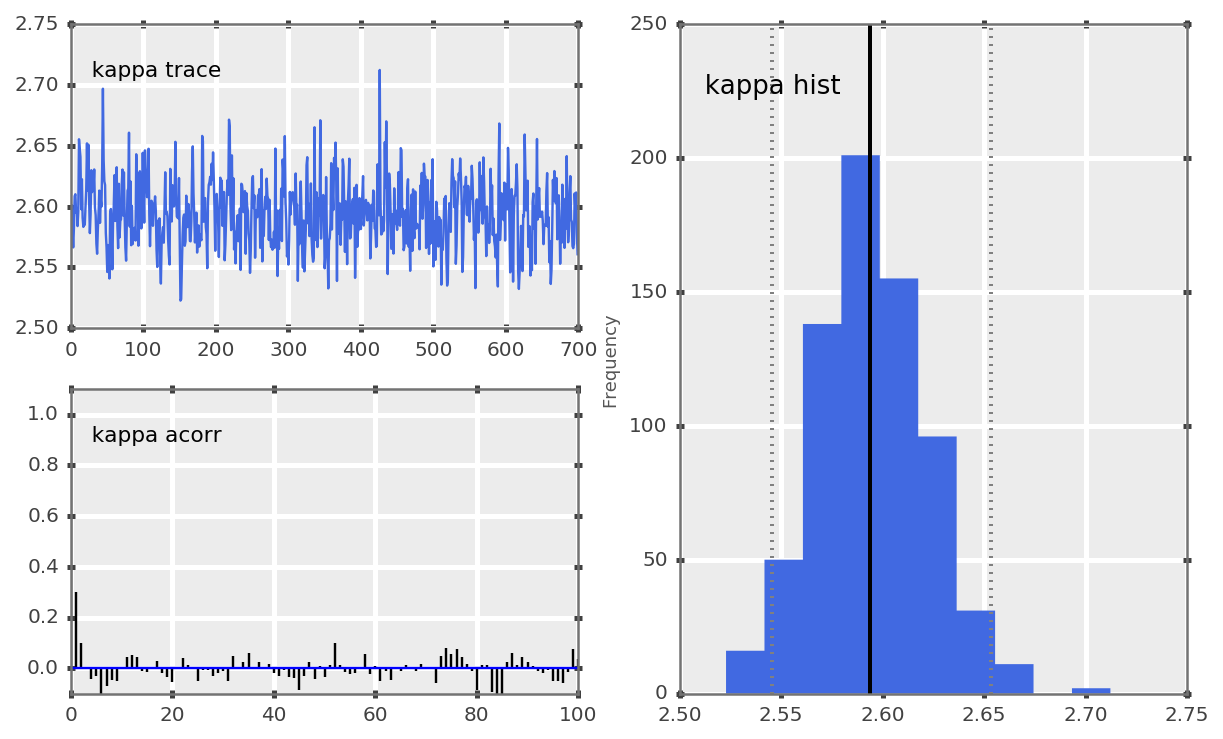

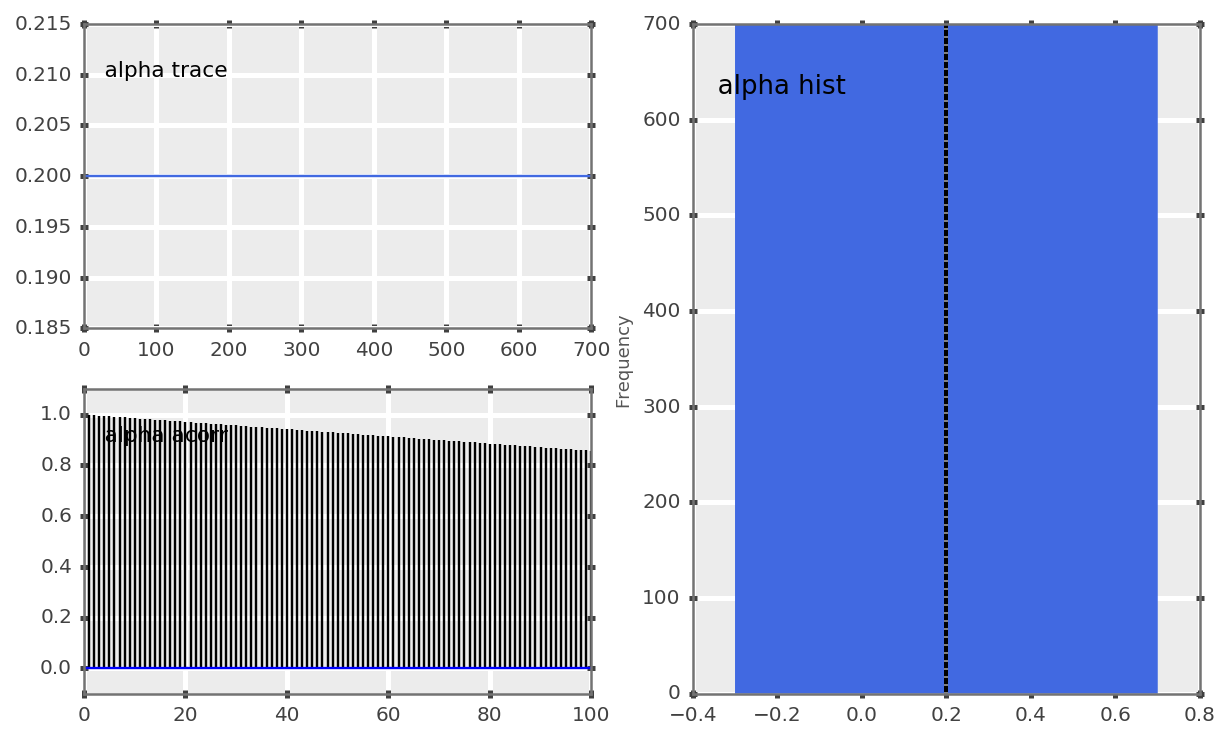

In [45]:
M = pymc.MCMC(gev_model)
M.sample(iter=40000, burn=5000, thin=50)
pymc.Matplot.plot(M)